# EX_12  🤖트랜스포머로 만드는 대화형 챗봇🤖

## 목표: 한국어 데이터로 챗봇 만들기

### lubric

1. 한국어 전처리를 통해 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.
2. 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.
3. 한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.

### 학습 목표

- 트랜스포머의 인코더 디코더 구조 이해하기
- 내부 단어 토크나이저 사용하기
- 셀프 어텐션 이해하기
- 한국어에도 적용해보기


### 🚩keyword

✔ seq2seq 모델의 한계, Transformer, d-model, num_layers, num_heads, dff, 포지셔널 인코딩(Positional Encoding), 어텐션(Attention)(인코더의 셀프 어텐션, 디코더의 마스크드 셀프 어텐션, 디코더의 인코더-디코더 어텐션

### start 

- Step 1. 데이터 수집하기
- Step 2. 데이터 전처리하기
- Step 3. SubwordTextEncoder 사용하기
- Step 4. 모델 구성하기
- Step 5. 모델 평가하기

### Step 1. 데이터 수집하기

In [1]:
import os
import re
import csv
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
print("슝=3")

슝=3


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11823


In [4]:
# null값 확인

print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


### Step 2. 데이터 전처리하기

정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여 단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제하는 것을 목표

In [5]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)
    
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [6]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


### Step 3. SubwordTextEncoder 사용하기

In [7]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3")

슝=3


In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [9]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print("슝=3")

슝=3


In [10]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('단어 집합의 크기 :',VOCAB_SIZE)

START_TOKEN의 번호 : [8178]
END_TOKEN의 번호 : [8179]
단어 집합의 크기 : 8180


패딩에 사용될 0번 토큰부터 마지막 토큰인 8,179번 토큰까지의 개수를 카운트하면 단어 집합의 크기는 8,180개

In [11]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5766, 611, 2495, 4167]
정수 인코딩 후의 21번째 답변 샘플: [2359, 7516, 7, 6279, 97, 1]


In [12]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[22]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [389, 811, 40, 413, 2]
기존 문장: 가장 확실한 건 뭘까 ?


In [13]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 16
questions 평균 길이 : 3.9402858834475176
answers 최대 길이 : 24
answers 평균 길이 : 4.71589275141673


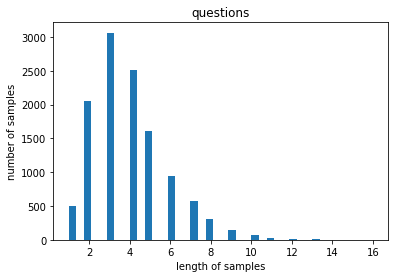

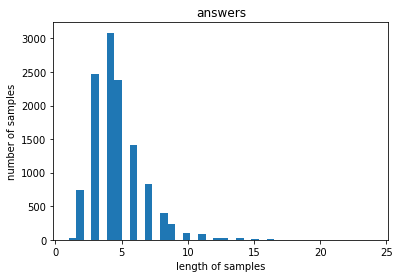

In [14]:
plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [17]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8180
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [18]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


길이 40을 맞추기 위해 뒤에 0이 패딩된 것을 확인할 수 있습니다.

교사 강요(Teacher Forcing) 사용

In [19]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [20]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

In [21]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


### Step 4. 모델 구성하기

#### 포지셔널 인코딩(Positional Encoding)
> 포지션 인코딩(Positional Encoding)은 트랜스포머 모델에 순서 정보가 반영되지 않는 문제를 해결하기 위해 사용

In [33]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  # 수식에서 pos/100002i/dim 값을 만들어주는 함수
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### 어텐션(Attention)
> 스케일 내적 어텐션(scaled dot product attention)은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 QQ와 KK의 유사도를 구함

> 멀티 헤드 어텐션은 어텐션 맵을 여럿 만들어 병렬처리 가능하게 만들어주는 것

In [34]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [35]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

#### 패딩 마스킹(Padding Masking)
> 패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법이다.

In [36]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

#### 룩 어헤드 마스킹(Look-ahead masking)
> 하지만 트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있습니다. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것입니다. 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법

In [37]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

#### 인코더(encoder)

In [38]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [39]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


#### 디코더(decoder)

In [40]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [41]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [42]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [43]:
# 모델 생성
# num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터 값
# 논문에서 num_layers는 6, d-Model은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3148288     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [44]:
# 손실 함수(Loss function)
# 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [45]:
# 커스텀 된 학습률(Learning rate)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

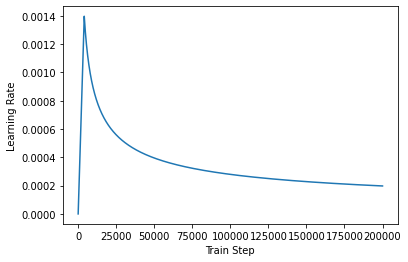

In [46]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [47]:
# 모델 컴파일

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [48]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 10s 53ms/step - loss: 1.1791 - accuracy: 0.0494
Epoch 3/20
185/185 [==============================] - 10s 53ms/step - loss: 1.0029 - accuracy: 0.0505
Epoch 4/20
185/185 [==============================] - 10s 53ms/step - loss: 0.9273 - accuracy: 0.0543
Epoch 5/20
185/185 [==============================] - 10s 53ms/step - loss: 0.8699 - accuracy: 0.0576
Epoch 6/20
185/185 [==============================] - 10s 53ms/step - loss: 0.8106 - accuracy: 0.0619
Epoch 7/20
185/185 [==============================] - 10s 53ms/step - loss: 0.7460 - accuracy: 0.0675
Epoch 8/20
185/185 [==============================] - 10s 53ms/step - loss: 0.6735 - accuracy: 0.0751
Epoch 9/20
185/185 [==============================] - 10s 53ms/step - loss: 0.5939 - accuracy: 0.0841
Epoch 10/20
185/185 [==============================] - 10s 53ms/step - loss: 0.5110 - accuracy: 0.0934
Epoch 11/20
185/185 [==============================] - 10s 53ms/step - loss: 0.42

### Step 5. 모델 평가하기

챗봇을 평가하기 위한 세 개의 함수를 구현합니다. sentence_generation 함수에서 decoder_inference 함수를 호출하고 decoder_inference 함수에서 preprocess_sentence 함수를 호출하는 구조입니다. 사용자의 입력이 파이썬의 문자열로 입력되면 preprocess_sentence 함수에서 문자열에 대한 전처리를 수행합니다. 해당 전처리는 학습 전 질문 데이터와 답변 데이터에서 했던 전처리와 동일한 전처리입니다. 전처리가 진행된 문자열에 대해서 decoder_inference 함수는 트랜스포머 모델에 전처리가 진행된 사용자의 입력을 전달하고, 디코더를 통해 계속해서 현재 시점의 예측. 다시 말해 챗봇의 대답에 해당하는 단어를 순차적으로 예측합니다. 여기서 예측된 단어들은 문자열이 아니라 정수인 상태이므로 decoder_inference 함수가 리턴하는 것은 결과적으로 정수 시퀀스입니다. sentence_generation 함수는 decoder_inference 함수로부터 전달받은 챗봇의 대답에 해당하는 정수 시퀀스를 문자열로 다시 디코딩을 하고 사용자에게 챗봇의 대답을 출력합니다.

In [52]:
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  # ex) 12시 땡! -> 12시 땡 !
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [53]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [54]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [55]:
sentence_generation('사랑해')

입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 사랑해요 !


'하늘 만큼 땅 만큼 사랑해요 !'

In [56]:
sentence_generation('안녕')

입력 : 안녕
출력 : 안녕하세요 .


'안녕하세요 .'

In [57]:
sentence_generation('저녁 9시')

입력 : 저녁 9시
출력 : 오늘은 쉬세요 .


'오늘은 쉬세요 .'

In [58]:
sentence_generation('데이터')

입력 : 데이터
출력 : 친구도 잘 몰라요 .


'친구도 잘 몰라요 .'

#### trial and error

이제야 NLP에 대한 큰 틀이 잡힌 것 같다. RNN 모델부터 혁신이라 할 수 있는 transfomer까지 또 따로 공부해 본 gan이 있어서 자연어 처리가 이런 거구나 알 것 같다. 트랜스포머는 s2s의 문제를 해결하기 위해 나온 모델로 생각보다 까다로웠지만 구조를 정확히 익히고 나니 큰 어려움이 없었고 결과도 한 번에 좋게 나와줘서 괜찮았던 노드이다. 사실 요즘 모델링보다는 데이터에 관심이 많은데 이 부분에 대해 깊게 공부해 보고 싶다. 데이터를 잘 다룰수록 더 내 목표에 맞는 결과 도출이 될 것 같다.

- 입력 : 사랑해/ 출력 : 하늘 만큼 땅 만큼 사랑해요 !

- 입력 : 저녁 9시/ 출력 : 오늘은 쉬세요 .

뭔가 사랑스러운 답변들이 나와서 기분이 좋았던 :D
